In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [101]:
200/60

3.3333333333333335

In [103]:
2*8*24*365

140160

In [106]:
10*8e3*8e3*8 / 1e9

5.12

In [109]:
(1.5e6 / 24) / (256) / (10)

24.4140625

In [114]:
#day x channels x time x probes x monkey
150*1584*7200*10*10*10 / 1e12

1.71072

In [118]:
#day x time x monkey * fps * tokens/frame
150*7200*10*16*1000 / 1e12

0.1728

In [132]:
7059 / 256

27.57421875

In [130]:
720/64

11.25

In [110]:
n_neurons = 1e6
n_seconds = 10e3
tokens_per_second = 50



In [111]:
tokens_per_second*n_seconds*n_neurons/1e9

500.0

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from os import path

from torch import nn
from torch.nn import functional as F
from torch.nn.functional import scaled_dot_product_attention
from torch.nn.attention import SDPBackend, sdpa_kernel
from tqdm import tqdm
from einops import rearrange
from torch.optim import AdamW, Adam

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from omegaconf import OmegaConf, open_dict
from experanto.datasets import ChunkDataset, SimpleChunkedDataset
from experanto.utils import LongCycler, MultiEpochsDataLoader
from experanto.dataloaders import get_multisession_dataloader

paths = ['dynamic29513-3-5-Video-full',
         'dynamic29514-2-9-Video-full',
         'dynamic29755-2-8-Video-full',
         'dynamic29647-19-8-Video-full',
         'dynamic29156-11-10-Video-full',
         'dynamic29623-4-9-Video-full',
         'dynamic29515-10-12-Video-full',
         'dynamic29234-6-9-Video-full',
         'dynamic29712-5-9-Video-full',
         'dynamic29228-2-10-Video-full'
        ]
full_paths = [path.join("/data/mouse_polly/", f) for f in paths]

from experanto.configs import DEFAULT_CONFIG as cfg
cfg.dataset.global_chunk_size = 16
cfg.dataset.global_sampling_rate = 8
cfg.dataset.modality_config.screen.include_blanks=True
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}

cfg.dataloader.num_workers=4
cfg.dataloader.prefetch_factor=1
cfg.dataloader.batch_size=32
cfg.dataloader.pin_memory=True

# the multiple dataloader is an iterator that returns a tuple of (key, batch)
train_dl = get_multisession_dataloader(full_paths, cfg)

In [3]:
import torch
from hiera import Hiera
tiny_hiera = Hiera(input_size=(16,144, 256),
                     num_heads=1, 
                     stages=(4, 8), 
                     q_pool=1, 
                     in_chans=1,
                     q_stride=(2, 2, 2),
                     mask_unit_size=(1, 8, 8),
                     patch_kernel=(3, 8, 8),
                     patch_stride=(2, 4, 4),
                     patch_padding=(1, 3, 3),
                     sep_pos_embed=True,)
#tiny_hiera = torch.compile(tiny_hiera).cuda().to(torch.bfloat16);
tiny_hiera = tiny_hiera.cuda().to(torch.bfloat16);

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class IndexedLinearReadout(nn.Module):
    """
    Readout module for MTM models with selectable weights based on 
    input IDs. Based on :class:`torch.nn.Linear`.
    """
    def __init__(
        self,
        unique_ids: int,
        in_features: int = 384,
        out_features: int = 1,
        bias: bool = True,
        device="cuda",
        dtype=torch.float32,
        init_std: float = 0.02,
    ):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.unique_ids = unique_ids
        self.in_features = in_features
        self.out_features = out_features
        self.init_std = init_std

        self.query = nn.Parameter(
            torch.empty(1, 4, unique_ids, 32, **factory_kwargs)
        )
        self.weight = nn.Parameter(
            torch.empty(unique_ids, in_features, out_features, **factory_kwargs)
        )
        if bias:
            self.bias = nn.Parameter(
                torch.empty(1, unique_ids, out_features, **factory_kwargs)
            )
        else:
            self.register_parameter('bias', None)
        self.init_weights()

    def init_weights(self, cutoff_factor: int = 3):
        """See `TorchTitan <https://github.com/pytorch/torchtitan/blob/40a10263c5b3468ffa53b3ac98d80c9267d68155/torchtitan/models/llama/model.py#L403>`__."""
        readout_std = self.in_features**-0.5
        nn.init.trunc_normal_(
            self.weight,
            mean=0.0,
            std=readout_std,
            a=-cutoff_factor * readout_std,
            b=cutoff_factor * readout_std,
        )
        readout_std = self.in_features**-0.5
        nn.init.trunc_normal_(
            self.query,
            mean=0.0,
            std=readout_std,
            a=-cutoff_factor * readout_std,
            b=cutoff_factor * readout_std,
        )
        if self.bias is not None:
            self.bias.data.zero_()

In [5]:
class ELU1(nn.Module):
    """
    Adapted from `NeuralPredictors <https://github.com/sinzlab/neuralpredictors/blob/main/neuralpredictors/layers/activations.py>`__.
    
    Elu activation function shifted by 1 to ensure that the
    output stays positive. That is:
    Elu1(x) = Elu(x) + 1
    """

    def forward(self, x, inplace=False, eps=0.0):
        return F.elu(x, inplace=inplace) + 1.0 + eps

In [6]:
class MouseHieraSmall(nn.Module):
    def __init__(self,
                 backbone,
                 dls,
                 t=16,
                 dim=512,
                 dim_head=32,
                 num_heads=4):
        super().__init__()
        self.backbone=backbone
        self.num_heads=num_heads
        self.dim_head=dim_head
        self.wk = nn.Linear(dim, dim_head * num_heads, bias=False)
        self.wv = nn.Linear(dim, dim_head * num_heads, bias=False)
        self.neuron_proj = nn.Linear(dim_head * num_heads, t, bias=False)
        self.readout = nn.ModuleDict()
        self.activation = ELU1()
        for k, v in dls.loaders.items():
            n_neurons = next(iter(v))["responses"].shape[-1]
            self.readout[k] = IndexedLinearReadout(n_neurons, in_features=dim_head*num_heads, out_features=1)
    
    def forward(self, x, key):
        x = self.backbone(x, return_intermediates=True)[1][-1]
        b, t, h, w, d = x.shape
        seq_len = t*h*w
        x = x.view(b, -1, d)
        k, v = self.wk(x), self.wv(x)
        q = self.readout[key].query
        n = q.shape[2]
        q = q.tile(b, 1, 1, 1)
        k = k.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2)
        v = v.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2)
        with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
            o = F.scaled_dot_product_attention(q, k, v)
        o = o.transpose(1,2).contiguous().view(b, -1, self.num_heads * self.dim_head)
        #o = torch.einsum("bnd, nft->bnt", o, w, )
        o = self.neuron_proj(o) # (B, N, D) -> (B, N, t)
        o = o + r.readout[key].bias
        o = F.elu(o, inplace=True) + 1.0
        return o

In [7]:
example_in = torch.ones(8,1,16,144, 256).to("cuda", torch.bfloat16)
out = tiny_hiera(example_in, return_intermediates=True);
features = out[-1][-1]
features.shape

backbone_dim = features[-1][-1].shape[-1]
r = MouseHieraSmall(tiny_hiera, train_dl, 16, backbone_dim, dim_head=32,num_heads=4)
#opt_r = torch.compile(r, )
opt_r = r
torch.set_float32_matmul_precision('high')
opt_r.backbone.to(torch.bfloat16).cuda();
opt_r = opt_r.train().to(torch.bfloat16).cuda()
opt_r = opt_r.cuda().to(torch.bfloat16)
opt_r = torch.compile(r).cuda().to(torch.bfloat16)
k, b = next(iter(train_dl))
videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
out = opt_r(videos, k);
criteria = nn.PoissonNLLLoss(log_input=False, reduction='mean')
opt = Adam(opt_r.parameters(), lr=1e-3, fused=True)
import pytorch_warmup as warmup
from torch.amp import autocast
warmup_scheduler = warmup.UntunedLinearWarmup(opt, )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 1e6, eta_min=1e-7)


In [9]:
opt_r.load_state_dict(torch.load("small_hiera_1016.pth", weights_only=True))

<All keys matched successfully>

In [89]:
from experanto.configs import DEFAULT_CONFIG as cfg
cfg.dataset.global_chunk_size = 16
cfg.dataset.global_sampling_rate = 8
cfg.dataset.modality_config.screen.include_blanks=False
cfg.dataset.modality_config.screen.sample_stride=16
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}

cfg.dataloader.num_workers=4
cfg.dataloader.prefetch_factor=1
cfg.dataloader.batch_size=32
cfg.dataloader.pin_memory=True

### Instantiate MultiDataloader

In [119]:
# the multiple dataloader is an iterator that returns a tuple of (key, batch)
train_dl = get_multisession_dataloader(full_paths[8:9], cfg)

In [120]:
targets, predictions = [],[]
with torch.no_grad():
    for i, (k, b) in tqdm(enumerate(train_dl)):
        videos = b["screen"].to("cuda", torch.bfloat16, non_blocking=True).permute(0,2,1,3,4)
        responses = b["responses"].to("cuda", torch.bfloat16, non_blocking=True)
        out = opt_r(videos, k);
        predictions.append(out.transpose(1,2).to(torch.float32).cpu().numpy())
        targets.append(responses.to(torch.float32).cpu().numpy())

50it [00:18,  2.67it/s]


In [121]:
r1 = np.vstack(np.vstack(predictions))

In [122]:
r2 = np.vstack(np.vstack(targets))

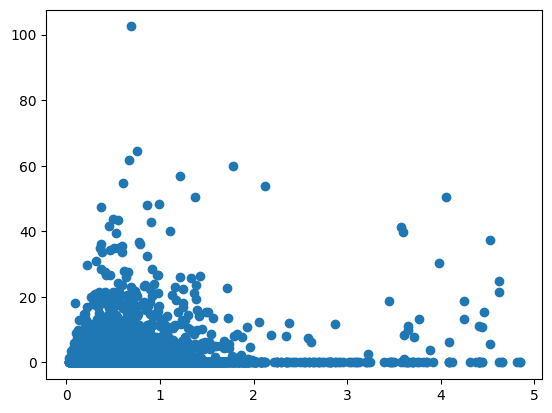

In [124]:
n=50
plt.scatter(r1[:,n], r2[:,n])

In [125]:
cs = []
for n in range(5000):
    c =  np.corrcoef(r1[...,n].flatten(), r2[...,n].flatten(), )[0,1]
    cs.append(c)

In [128]:
np.stack(cs).mean()

np.float64(0.1895119140066486)

In [83]:
p

Parameter containing:
tensor([[[-0.0947, -0.0845,  0.0127,  ...,  0.1289, -0.0781,  0.1367],
         [ 0.0293,  0.1069,  0.0042,  ...,  0.0767, -0.1338, -0.0284],
         [ 0.0042,  0.1328,  0.0064,  ..., -0.1074,  0.0133,  0.0664],
         ...,
         [-0.1064, -0.0840, -0.0189,  ...,  0.0104, -0.0133, -0.1113],
         [-0.0194,  0.1060, -0.0442,  ...,  0.0630, -0.0260, -0.0304],
         [-0.0295,  0.0090,  0.0825,  ..., -0.0317, -0.0461,  0.1133]]],
       device='cuda:0', dtype=torch.bfloat16, requires_grad=True)

In [84]:
torch.numel(p)

221184

In [85]:
v=0
for n, p in tiny_hiera.named_parameters():
    v+=torch.numel(p)

In [86]:
v

4403272

In [88]:
4*32*16

2048